In [1]:
%cd /home/mrearle/repos/R2R-EnvDrop-ObjAttn/

/mnt-homes/kraken/mrearle/repos/R2R-EnvDrop-ObjAttn


# Imports

In [2]:
import sys
import torch
import networkx as nx

metadata_parser_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/metadata_parser'
if metadata_parser_path not in sys.path:
    sys.path.append(metadata_parser_path)

mattersim_path = '/home/mrearle/datasets/Matterport3DSimulator/build'
if mattersim_path not in sys.path:
    sys.path.append(mattersim_path)
    
src_path = '/home/mrearle/repos/R2R-EnvDrop-ObjAttn/r2r_src'
if src_path not in sys.path:
    sys.path.append(src_path)


In [3]:
from parse_house_segmentations import HouseSegmentationFile

# Parameters

In [4]:
from param import args

Optimizer: Using RMSProp
Using device: cuda
_CudaDeviceProperties(name='NVIDIA GeForce GTX 1080 Ti', major=6, minor=1, total_memory=11178MB, multi_processor_count=28)


	Training model default in experiment default




In [5]:
# Model args
args.name = 'agent_bt_val'
args.attn = 'soft'
args.train = 'validlistener'
args.angle_feat_size = 128
args.accumulateGrad = True
args.featdropout = 0.4
args.subout = 'max'
args.optim = 'rms'
args.lr = 1e-4
args.iters = 10
args.maxAction = 35

# Obj attn args
args.obj_attn_type = "connection"
args.max_obj_number = 32
args.obj_aux_task = True
args.obj_aux_task_weight = 0.1
args.include_objs = True
args.include_objs_lstm = False
args.reduced_envs = True
args.buffer_objs = False
args.dataset='craft'

# Required for visualization
args.logging_vis = True

# Setup Agent

## Imports

In [6]:
from agent import Seq2SeqAgent
from collections import defaultdict
import json
import numpy as np
import h5py
from collections import OrderedDict
from train import setup, read_vocab, Tokenizer, TRAIN_VOCAB, read_img_features, R2RBatch, Evaluation

log_dir = args.log_dir
FEATURE_FILE = "/home/mrearle/storage/img_features/ResNet-152-imagenet.hdf5"

Namespace(CANDIDATE_FEATURES='img_features/ResNet-152-candidate.tsv', IMAGENET_FEATURES='img_features/ResNet-152-imagenet.tsv', OBJECT_CLASS_FILE='/workspace1/mrearle/object_classes.json', OBJECT_FEATURES='/workspace1/mrearle/object_features_filtered.hdf5', TRAINVAL_VOCAB='tasks/R2R/data/trainval_vocab.txt', TRAIN_VOCAB='tasks/R2R/data/train_vocab.txt', accumulateGrad=True, accumulate_grad=False, aemb=64, alpha=0.5, angle_feat_size=128, attn='soft', aug=None, batchSize=64, beam=False, bidir=True, buffer_objs=False, candidate_mask=False, candidates=1, dataset='craft', device=device(type='cuda'), dropout=0.5, encode='word', epsilon=0.1, experiment='default', fast_train=False, featdropout=0.4, feature_size=2048, features='imagenet', features_fast='img_features/ResNet-152-imagenet-fast.tsv', feedback='sample', gamma=0.9, ignoreid=-100, include_objs=True, include_objs_lstm=False, iters=10, listener=None, load=None, loadOptim=False, log_dir='snap/default/default', logging_vis=True, lr=0.0001

## Environments

In [7]:
setup()

vocab = read_vocab(TRAIN_VOCAB)
tok = Tokenizer(vocab=vocab, encoding_length=args.maxInput)

feat_h5 = h5py.File(FEATURE_FILE, "r")
obj_feat_h5 = h5py.File(args.OBJECT_FEATURES, "r")

featurized_scans = set(feat_h5.keys())

train_env = R2RBatch(
    feature_store=feat_h5, object_feat_store=obj_feat_h5, batch_size=args.batchSize, splits=["train"], tokenizer=tok
)

val_env_names = ["val_unseen"]

val_envs = OrderedDict(
        (
            (
                split,
                (
                    R2RBatch(
                        feature_store=feat_h5,
                        object_feat_store=obj_feat_h5,
                        batch_size=args.batchSize,
                        splits=[split],
                        tokenizer=tok,
                    ),
                    Evaluation([split], featurized_scans, tok),
                ),
            )
            for split in val_env_names
        )
    )

W2I is defaultdict True
OLD_VOCAB_SIZE 991
VOCAB_SIZE 992
VOACB 991
The feature size is 2048
Using dataset semantically_richer_instructions/R2R_craft_train.json for split train (arg: craft)
Loading navigation graphs for 21 scans
R2RBatch loaded with 1630 instructions, using splits: train
The feature size is 2048
Using dataset semantically_richer_instructions/R2R_craft_val_unseen.json for split val_unseen (arg: craft)
Loading navigation graphs for 11 scans
R2RBatch loaded with 783 instructions, using splits: val_unseen
Using dataset semantically_richer_instructions/R2R_craft_val_unseen.json for split val_unseen (arg: craft)


## Setup Agent

In [8]:
object_attentions = []
def obj_attention_hook(model, input, output):
    if model.traj_info is None:
        return None

    _, attentions, _ = output
    traj_info = model.traj_info
    attns = attentions.detach().cpu()
    object_attentions.append((traj_info, attns))
    model.traj_info = None
    
viewpoint_attentions = []
def view_attention_hook(model, input, output):
    _, _, attn, _, _ = output
    viewpoint_attentions.append(attn.detach().cpu())

In [9]:
agent = Seq2SeqAgent(train_env, "", tok, args.maxAction)

agent.decoder.connectionwise_obj_attn.register_forward_hook(obj_attention_hook)
agent.decoder.register_forward_hook(view_attention_hook)

args.load = 'snap/obj/craft_obj(32)_aux(0.1)_reduced/state_dict/best_val_unseen'
print(
    "Loaded the listener model at iter %d from %s"
    % (agent.load(args.load), args.load),
    flush=True,
)

Using Bidir in EncoderLSTM
ObjAttention: Using class ConnectionwiseObjectAttention
Listener: Done Instantiating Model. Initializing Optimizers
Listener: Done Instantiating Optimizers. Initializing Loss
Listener: Done Instantiating Loss. Initializing Logs
Listener: Flushed
Listener: Done Instantiating Logs. Listener Initialized
Loaded the listener model at iter 25500 from snap/obj/craft_obj(32)_aux(0.1)_reduced/state_dict/best_val_unseen


In [10]:
for env_name, (env, evaluator) in val_envs.items():
    agent.logs = defaultdict(list)
    agent.env = env

    iters = None
    agent.test(use_dropout=False, feedback="argmax", iters=1)
    agent_result = agent.get_results()

    break

# Visualization

## Parse trajectory data

In [11]:
import importlib
from visualization_v2 import instruction_utils, iterator_utils, plotting, visualization_data_parser
importlib.reload(visualization_data_parser)
importlib.reload(iterator_utils)
importlib.reload(instruction_utils)
importlib.reload(plotting)

get_result_iterator = iterator_utils.get_traj_result_iterator
map_result_data = iterator_utils.map_result
get_instruction_function = instruction_utils.get_instruction_function
make_plots = plotting.make_plots

In [12]:
get_instruction = get_instruction_function()
result_iterator = get_result_iterator(object_attentions, viewpoint_attentions)

## Plotting

In [13]:
import matplotlib
%matplotlib inline

In [14]:
# Initialize iterator to be able to send environment
next(result_iterator)
result_iterator.send(-1)
pass

In [28]:
# Get environment information and results
env_i = 0
env_data = map_result_data(env_i, agent_result, result_iterator.send(env_i), get_instruction)

In [29]:
env_data['hook_info']['instr_id']

'4156_0'

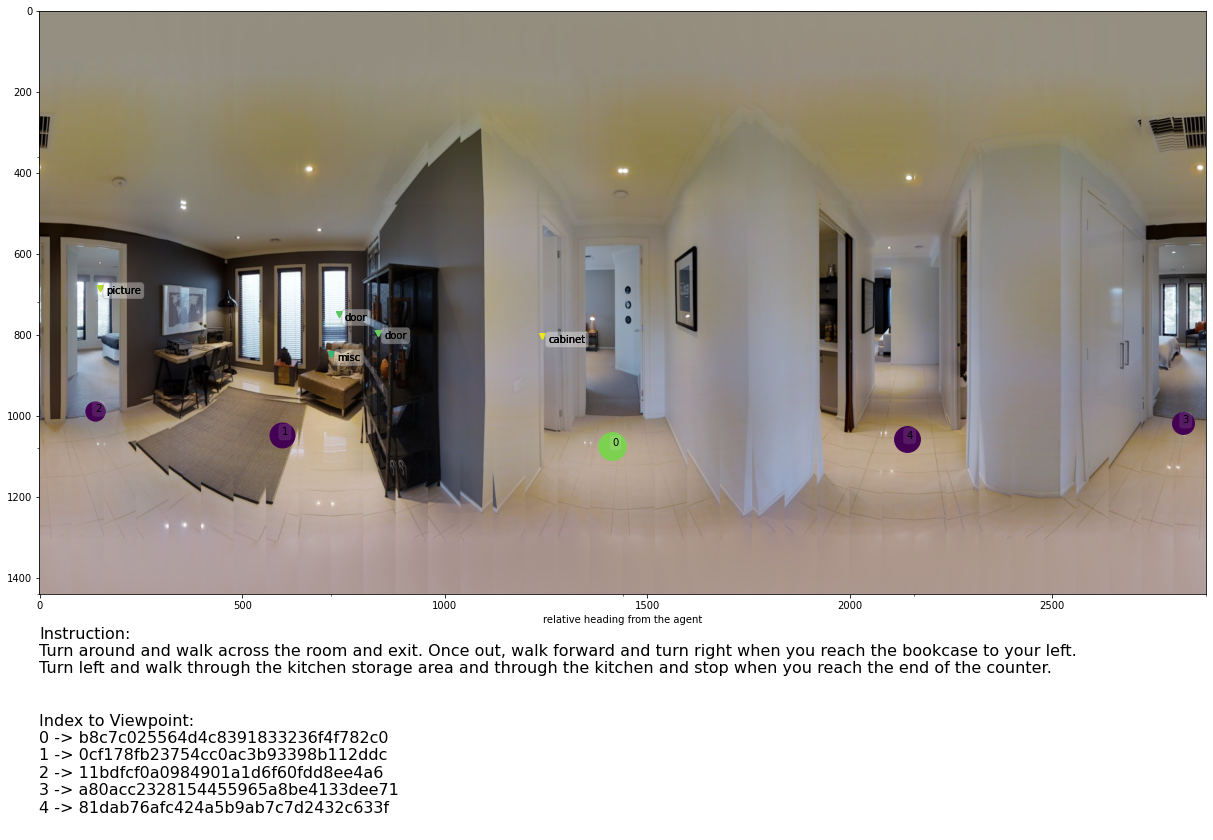

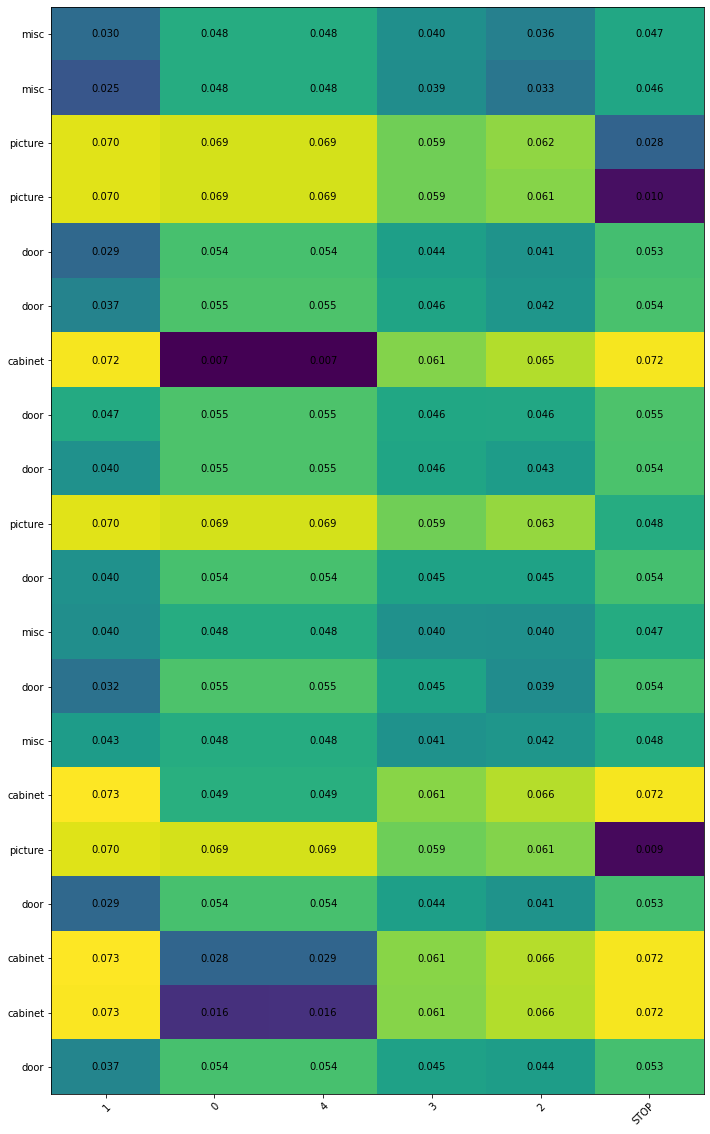

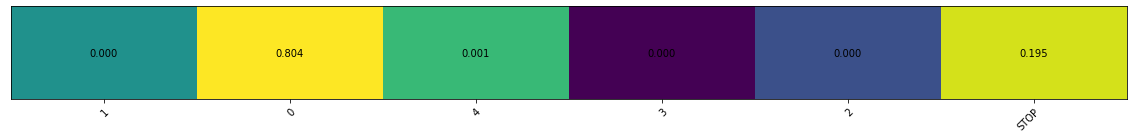

In [30]:
# Finally plot
make_plots(
    info=env_data['hook_info'],
    viewpoint_attn=env_data['view_attn'],
    candidates=env_data['viewpoint_names'],
    object_names=env_data['object_names'],
    object_attention=env_data['object_attn'],
    instruction=env_data['instruction'],
)